# Importing useful libraries 

In [47]:
import pandas as pd # For dataframe related tasks
import numpy as np # For numerical related tasks

# For natural language related tasks
import nltk 
nltk.download('punkt')

import warnings

warnings.filterwarnings('ignore')

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /home/micky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data fetching

In [21]:
# Reading the data

df = pd.read_csv('../data/spam.csv',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data Cleaning

In [22]:
# Let us drop the last 3 columns

del_columns = ['Unnamed: 2','Unnamed: 3','Unnamed: 4']
df = df.drop(columns = del_columns)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [23]:
# Now let us change the column names

df = df.rename(columns = {
                        'v1':'target',
                        'v2':'message'    
                         })
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [24]:
# Let us see how many rows and columns our dataset has

df.shape

(5572, 2)

In [25]:
# Let us see info of our dataset

df.describe()

,target,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [27]:
# Let us change the ham,spam into 0,1

df['target'] = df['target'].apply(lambda x: 0 if x == 'ham' else 1)
df.head(5)

,target,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
# Let us see if there are any missing values

df.isna().sum()

target     0
message    0
dtype: int64

In [30]:
# Let us check if there are any duplicates

df.duplicated().sum()

403

In [31]:
# Let us drop these duplicates

df = df.drop_duplicates(keep = 'first')
df.shape

(5169, 2)

# EDA

In [34]:
# Let us see if our data is highly skewed or not

df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

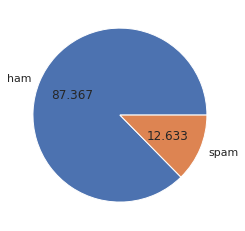

In [73]:
'''
As we can see from the above the data is skewed
So it is better not to do Machine Learning without 
doing some adjustments

Let us see the skewness using pie chart
'''

plt.pie(df['target'].value_counts(),
       labels = ['ham','spam'],
       autopct='%.3f'
       )
plt.savefig('../charts/pie_chart_of_spam_ham.png')
plt.show()

In [51]:
# Let us create a new column containing number of characters

df['num_char'] = df['message'].apply(len)
df.head()

,target,message,num_char
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [52]:
# Let us create a new column containing number of words

df['num_words'] = df['message'].apply(lambda x: len(nltk.word_tokenize(x)))
df.head()

,target,message,num_char,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [53]:
# Let us create a new column containing number of sentences

df['num_sent'] = df['message'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head()

,target,message,num_char,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [55]:
# Let us see how these columns are distributed

df[['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.453279,1.947185
std,58.236293,13.324793,1.362406
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,28.000000


In [62]:
# Now let us specifically see for the ham messages

df[df['target'] == 0][['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.120903,1.799601
std,56.358207,13.493725,1.278465
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [63]:
# Now let us specifically see for the spam messages

df[df['target'] == 1][['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


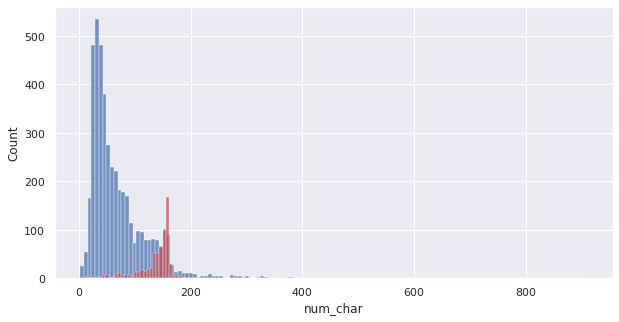

In [72]:
'''
From the above we can clearly see that spam messages
have more words and sentences than the normal ones.

Let us use a histogram plot to see more
'''

sns.set()
plt.figure(figsize=(10,5))
sns.histplot(df[df['target'] == 0]['num_char'])
sns.histplot(df[df['target'] == 1]['num_char'],color='r')
plt.savefig('../charts/hist_plot_of_spam_ham.png')
plt.show()

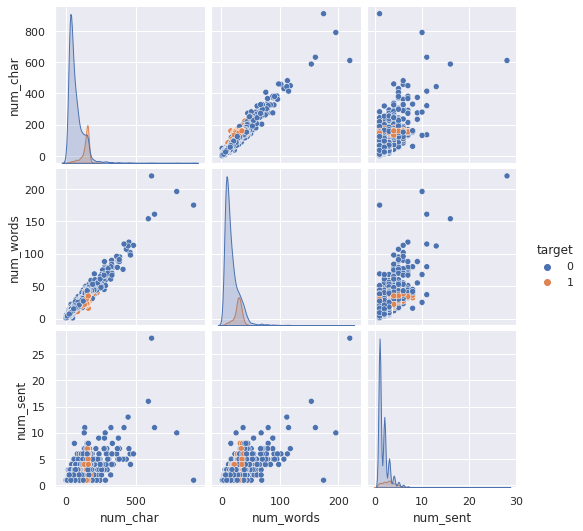

In [75]:
# Let us see plot the whole column relation 


sns.pairplot(df,hue='target')
plt.savefig('../charts/over_all_view.png')
plt.show()

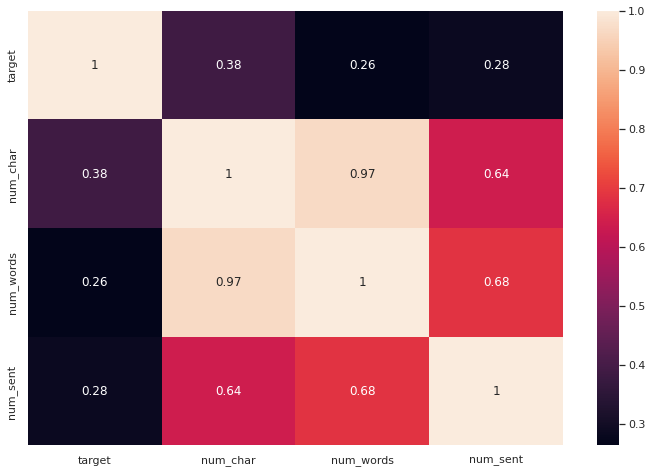

In [85]:
# Let us now try to plot the correlation matrix

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True)
plt.savefig('../charts/correlation_plot.png')
plt.show()

# Data Preprocessing